In [1]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import xgboost as xgb  #GBM algorithm
from xgboost import XGBRegressor
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   # Perforing grid search

from IPython.display import display

# remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('data/other_new_train.csv')
test_data = pd.read_csv('data/other_new_test.csv')

print train_data.shape
display(train_data.head(1))
# display(train_data.info())

print test_data.shape
display(test_data.head(1))
# display(test_data.info())
train_length = train_data.shape[0]

(1460, 290)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Id,SalePrice
0,4.110874,4.189655,9.04204,7,5,2003,2003,5.283204,6.561031,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,12.247699


(1459, 289)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Id
0,3.044522,4.394449,9.360741,5,6,1961,1961,0.0,6.150603,4.976734,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1461


In [3]:
import math

def common_num_range(start,stop,step):
    
    startlen = stoplen = steplen = 0
    if '.' in str(start):
        startlen = len(str(start)) - str(start).index('.') - 1
    if '.' in str(stop):
        stoplen = len(str(stop)) - str(stop).index('.') - 1
    if '.' in str(step):
        steplen = len(str(step)) - str(step).index('.') - 1
    
    maxlen = startlen
    if stoplen > maxlen:
        maxlen = stoplen
    if steplen > maxlen:
        maxlen = steplen
    
    power = math.pow(10, maxlen)
    
    if startlen == 0 and stoplen == 0 and steplen == 0:
        return range(start, stop, step)
    else:
        return [num / power for num in range(int(start*power), int(stop*power), int(step*power))]


In [4]:
train_id = train_data['Id']
train_Y = train_data['SalePrice']
train_data.drop(['Id', 'SalePrice'], axis=1, inplace=True)
train_X = train_data

test_Id = test_data['Id']
test_data.drop('Id', axis=1, inplace=True)
test_X = test_data

In [5]:
# formatting for xgb
dtrain = xgb.DMatrix(train_X, label=train_Y)
dtest = xgb.DMatrix(test_X)

# XGBoost  & Parameter Tuning

Ref: [Complete Guide to Parameter Tuning in XGBoost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

## Parameters Tuning Plan

The overall parameters can be divided into 3 categories:

1. General Parameters: Guide the overall functioning
2. Booster Parameters: Guide the individual booster (tree/regression) at each step
3. Learning Task Parameters: Guide the optimization performed

In `XGBRegressor`:
```
class xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', nthread=-1, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
```

In [6]:
def model_cross_validate(xgb_regressor, cv_paramters, dtrain, 
              cv_folds = 5, early_stopping_rounds = 50, perform_progress=False):
    """
    xgb model cross validate to choose best param from giving cv_paramters.
    
    @param cv_paramters:dict,where to choose best param. {'param':[1,2,3]}
    @param dtrain:xgboost.DMatrix, training data formatted for xgb
    @param early_stopping_rounds: Activates early stopping.Stop when perfomance 
                                  does not improve for some rounds
    """
    # get initial parameters
    xgb_param = xgb_regressor.get_xgb_params()
    
    # save best param
    best_param = {}
    best_cvresult = None
    min_mean_rmse = float("inf")
    
    for param, values in cv_paramters.items():
        print '===========Tuning paramter:',param,'==========='
        for value in values:
            # set the param's value
            xgb_param[param] = value
            
            # cv to tune param from values
            cvresult = xgb.cv(xgb_param, dtrain, num_boost_round=xgb_param['n_estimators'], 
                              nfold=cv_folds, metrics='rmse', 
                              early_stopping_rounds=early_stopping_rounds)

            # calcuate the mean of several final rmses
            round_count = cvresult.shape[0]
            mean_rmse = cvresult.loc[round_count-11:round_count-1,'test-rmse-mean'].mean()
            
            if perform_progress:
                std_rmse = cvresult.loc[round_count-11:round_count-1,'test-rmse-std'].mean()

                if isinstance(value, int):
                    print "%s=%d CV RMSE : Mean = %.7g | Std = %.7g" % (param, value, mean_rmse, std_rmse)
                else:
                    print "%s=%f CV RMSE : Mean = %.7g | Std = %.7g" % (param, value, mean_rmse, std_rmse)

            if mean_rmse < min_mean_rmse:
                best_param[param] = value
                best_cvresult = cvresult
                min_mean_rmse = mean_rmse
        
        print "best ", param, " = ", best_param[param]
    
    return best_param, min_mean_rmse, best_cvresult


In [7]:
def model_fit(regressor, train_x, train_y, performCV=True, 
              printFeatureImportance=True, cv_folds=5):
    
    # fir the train data
    regressor.fit(train_x, train_y)
    
    # Predict training set
    train_predictions = regressor.predict(train_x)
    mse = metrics.mean_absolute_error(train_y, regressor.predict(train_x))
    print "Model training report:"
    print("MSE: %.9f" % mse)
    
    # Perform cross-validation
    if performCV:
        cv_score = cross_validation.cross_val_score(regressor, train_x, train_y, 
                                               cv=cv_folds, scoring='r2')
        print "CV Score : Mean = %.7g | Std = %.7g | Min = %.7g | Max = %.7g" % \
                (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
    
    # Print Feature Importance
    if printFeatureImportance:
        feature_importances = pd.Series(regressor.feature_importances_, train_x.columns.values)
        feature_importances = feature_importances.sort_values(ascending=False)
        feature_importances= feature_importances.head(40)
        feature_importances.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
    
    return regressor, feature_importances

Baseline XGBRegressor

Model training report:
MSE: 0.063587811
CV Score : Mean = 0.8920431 | Std = 0.01035349 | Min = 0.8822041 | Max = 0.9100239


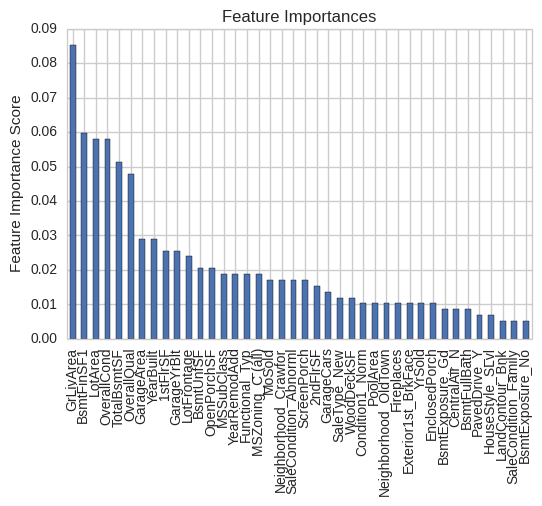

In [8]:
xgb_regressor = XGBRegressor(seed=10)
xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)

### 1. Choose a relatively high learning_rate,optimum n_estimators

In [ ]:
param_test1 = {'n_estimators':range(100,210,10)}

xgb_regressor = XGBRegressor(
                learning_rate =0.02,
    
                max_depth=5,
                min_child_weight=1,
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

best_param, min_mean_rmse, best_cvresult = \
                model_cross_validate(xgb_regressor, param_test1, dtrain, perform_progress=True)

print 'best params:', best_param
print 'min_mean_rmse:', min_mean_rmse

In [ ]:
xgb_regressor = XGBRegressor(
                learning_rate=0.02,
                n_estimators=200,
    
                max_depth=5,
                min_child_weight=1,
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)

### 2.Fix learning rate and number of estimators for tuning tree-based parameters

Tune `max_depth` and `min_child_weight`

In [ ]:
param_test2 = {'max_depth':range(1,6,1),
               'min_child_weight':range(1,8,1)}

xgb_regressor = XGBRegressor(
                learning_rate=0.02,
                n_estimators=200,
    
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

best_param, min_mean_rmse, best_cvresult = \
                model_cross_validate(xgb_regressor, param_test2, dtrain, perform_progress=True)

print 'best params:', best_param
print 'min_mean_rmse:', min_mean_rmse

In [ ]:
xgb_regressor = XGBRegressor(
                learning_rate=0.2,
                n_estimators=200,
                max_depth=4,
                min_child_weight=5,
    
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)

Tune `gamma`,Minimum loss reduction required to make a further partition on a leaf node of the tree. 

In [ ]:
param_test2 = {'gamma':[0, 0.1, 0.01, 0.001,0.0001]}

xgb_regressor = XGBRegressor(
                learning_rate=0.2,
                n_estimators=200,
                max_depth=4,
                min_child_weight=5,
    
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

best_param, min_mean_rmse, best_cvresult = \
                model_cross_validate(xgb_regressor, param_test2, dtrain, perform_progress=True)

print 'best params:', best_param
print 'min_mean_rmse:', min_mean_rmse

In [ ]:
xgb_regressor = XGBRegressor(
                learning_rate=0.1,
                n_estimators=190,
                max_depth=3,
                min_child_weight=2,
                gamma=0.001,
                
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)

Tune `subsample` and `colsample_bytree`

- subsample : Subsample ratio of the training instance.
- colsample_bytree : Subsample ratio of columns when constructing each tree

In [ ]:
param_test2 = {'subsample':common_num_range(0.6, 0.9, 0.01),
               'colsample_bytree':common_num_range(0.6, 0.9, 0.01)}

xgb_regressor = XGBRegressor(
                learning_rate=0.1,
                n_estimators=190,
                max_depth=3,
                min_child_weight=2,
                gamma=0.001,
                
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

best_param, min_mean_rmse, best_cvresult = \
                model_cross_validate(xgb_regressor, param_test2, dtrain, perform_progress=True)

print 'best params:', best_param
print 'min_mean_rmse:', min_mean_rmse

In [ ]:
xgb_regressor = XGBRegressor(
                learning_rate=0.1,
                n_estimators=190,
                max_depth=3,
                min_child_weight=2,
                gamma=0.001,
                subsample=0.71,
                colsample_bytree=0.66,
    
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)

In [ ]:
param_test2 = {'reg_lambda':common_num_range(0, 0.5, 0.01),
               'reg_alpha':common_num_range(0, 0.5, 0.01)}

xgb_regressor = XGBRegressor(
                learning_rate=0.1,
                n_estimators=190,
                max_depth=3,
                min_child_weight=2,
                gamma=0.001,
                subsample=0.71,
                colsample_bytree=0.66,
    
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

best_param, min_mean_rmse, best_cvresult = \
                model_cross_validate(xgb_regressor, param_test2, dtrain, perform_progress=True)

print 'best params:', best_param
print 'min_mean_rmse:', min_mean_rmse

In [ ]:
xgb_regressor = XGBRegressor(
                learning_rate=0.1,
                n_estimators=190,
                max_depth=3,
                min_child_weight=2,
                gamma=0.001,
                subsample=0.71,
                colsample_bytree=0.66,
                reg_lambda = 0.32,
                reg_alpha = 0.32,
    
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)                                           

Paramters Micro-tuning

```
xgb_regressor = XGBRegressor(
                learning_rate=0.1,
                n_estimators=190,
                max_depth=3,
                min_child_weight=2,
                gamma=0.001,
                subsample=0.71,
                colsample_bytree=0.66,
                reg_lambda = 0.32,
                reg_alpha = 0.32,
    
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)
```

In [ ]:
xgb_regressor = XGBRegressor(
                learning_rate=0.01,
                n_estimators=3000,
                max_depth=3,
                min_child_weight=2,
                gamma=0.001,
                subsample=0.71,
                colsample_bytree=0.66,
                reg_lambda = 0.32,
                reg_alpha = 0.32,
    
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)

In [ ]:
xgb_regressor = XGBRegressor(
                learning_rate=0.01,
                n_estimators=3000,
                max_depth=3,
                min_child_weight=2,
                gamma=0.001,
                subsample=0.72,
                colsample_bytree=0.63,
                reg_lambda = 0.29,
                reg_alpha = 0.34,
    
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)

In [ ]:
xgb_predictions = xgb_regressor.predict(test_X)
xgb_predictions = np.power(np.e, xgb_predictions) - 1

submission = pd.DataFrame({
        "Id": test_Id,
        "SalePrice": xgb_predictions
    })

submission.to_csv("result/xgb_param_tune_predictions_2_11.csv", index=False)

print "Done."

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor  #GBM algorithm

gbm_regressor = GradientBoostingRegressor(
                learning_rate=0.09,
                n_estimators=180,
                max_depth=3, 
                max_features = 60,
                min_samples_leaf=1,
                min_samples_split=27,
                subsample = 0.82,
                random_state=10,
                verbose=0)
gbm_regressor, feature_importances = model_fit(gbm_regressor, train_X, train_Y)

gbm_predictions = gbm_regressor.predict(test_X)
gbm_predictions = np.power(np.e, gbm_predictions) - 1

predictions = (gbm_predictions + xgb_predictions) / 2
submission = pd.DataFrame({
        "Id": test_Id,
        "SalePrice": predictions
    })

submission.to_csv("result/xgb_gbm_param_tune_predictions_2_11.csv", index=False)

print "Done."